# Visualise signal analysis

This notebook demonstrates the different methods for extracting the frequency from a signal. The signal is a ground truth signal from the dataset. The signal is preprocessed by filtering and normalizing it. The frequency is then extracted using the FFT, peak counting, and crossing point methods. The results are compared to the ground truth frequency.

In [1]:
import respiration.dataset as repository

dataset = repository.from_default()

subject = 'Proband16'
scenario = '101_natural_lighting'

In [2]:
hyperparameters = {
    'quality_level': 0.1,
    'quality_level_rv': 0.05,
    'filter_lowpass': 0.1,
    'filter_highpass': 0.6,
}

In [3]:
gt_signal, gt_sample_rate = dataset.get_ground_truth_rr_signal(subject, scenario)

## Signal Preprocessing

In [4]:
import respiration.preprocessing as preprocessing

signal_filter = preprocessing.butterworth_filter(
    gt_signal,
    gt_sample_rate,
    lowpass=hyperparameters['filter_lowpass'],
    highpass=hyperparameters['filter_highpass'],
)
signal_normalization = preprocessing.normalize_signal(
    signal_filter,
)

processed_signal = signal_normalization

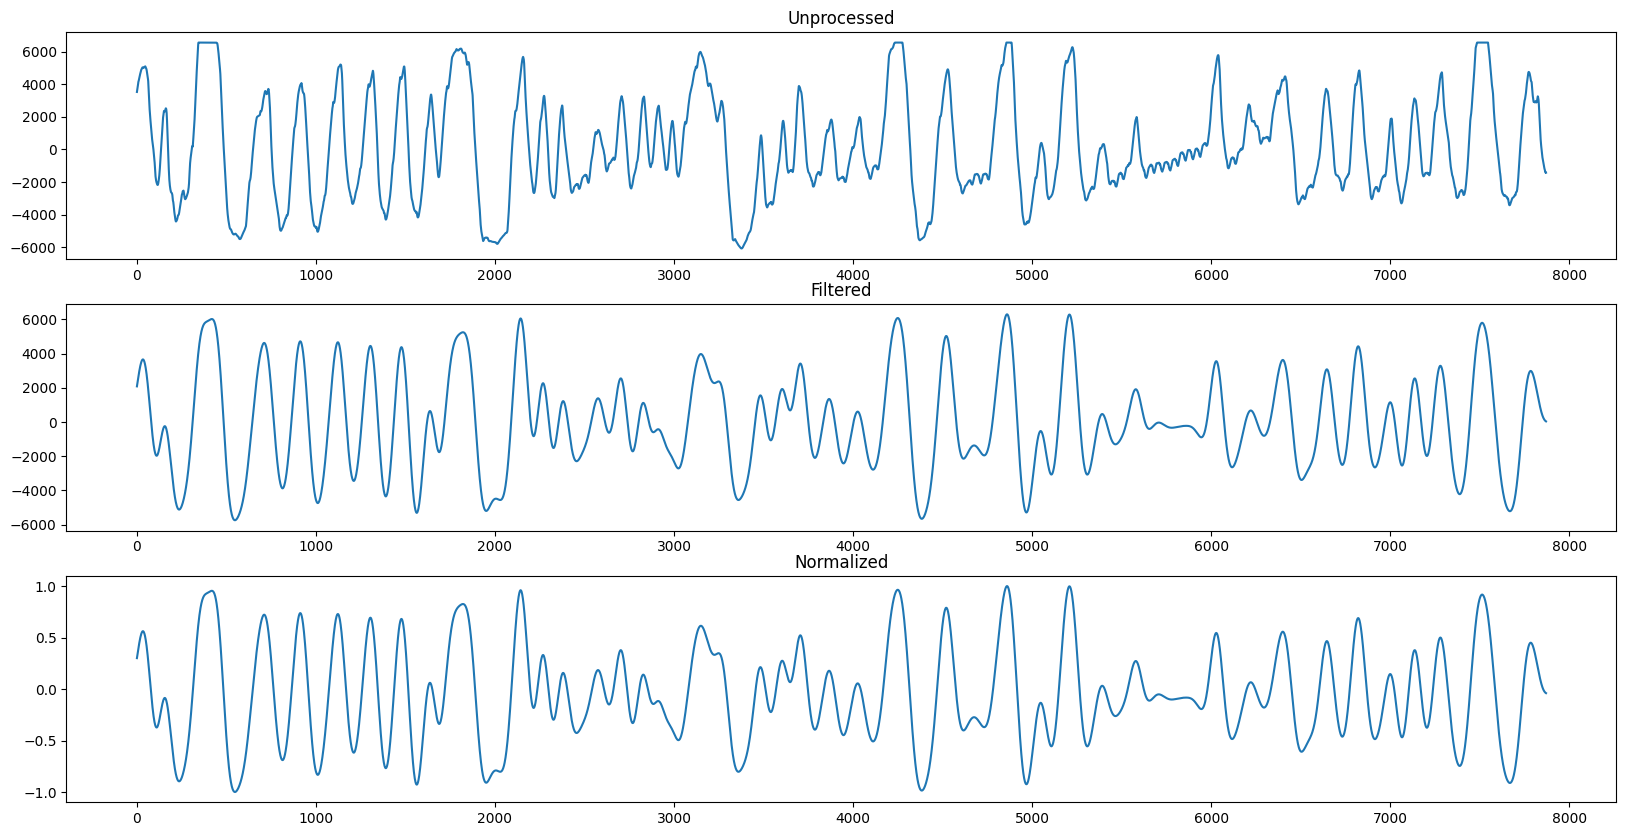

In [5]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 1, figsize=(20, 10))

axs[0].plot(gt_signal)
axs[0].set_title('Unprocessed')

axs[1].plot(signal_filter)
axs[1].set_title('Filtered')

axs[2].plot(signal_normalization)
axs[2].set_title('Normalized')

plt.show()

## Frequency Extraction with FFT

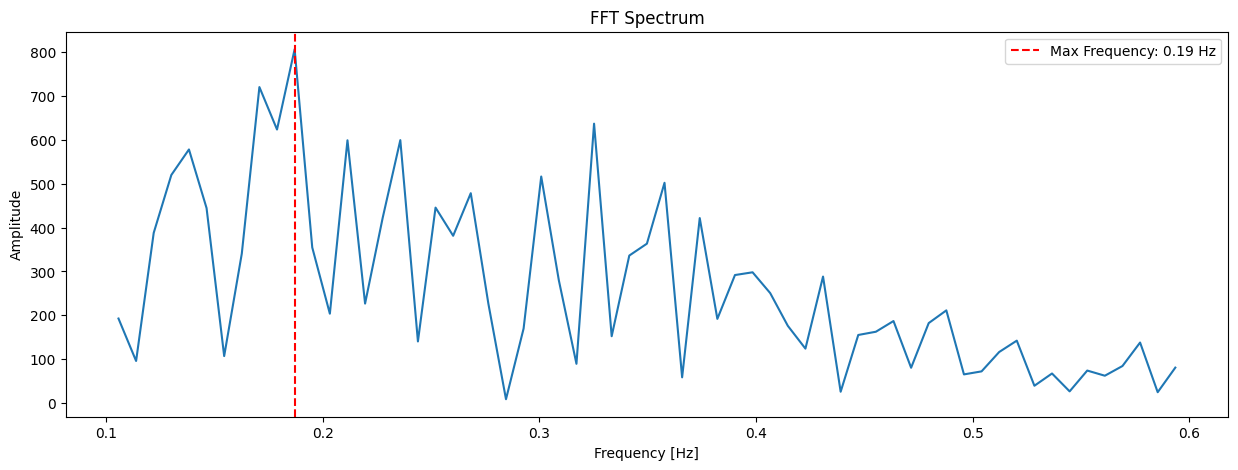

In [6]:
from respiration.analysis import *

frequencies, fft_result = fft_spectrum(
    processed_signal,
    gt_sample_rate,
    min_freq=hyperparameters['filter_lowpass'],
    max_freq=hyperparameters['filter_highpass']
)

# Plot the FFT spectrum
plt.figure(figsize=(15, 5))
plt.plot(frequencies, np.abs(fft_result))
plt.title('FFT Spectrum')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')

# Mark the max frequency
max_freq = frequencies[np.argmax(np.abs(fft_result))]
plt.axvline(max_freq, color='r', linestyle='--', label=f'Max Frequency: {max_freq:.2f} Hz')
plt.legend()

plt.show()

## Frequency Extraction with Peak Counting

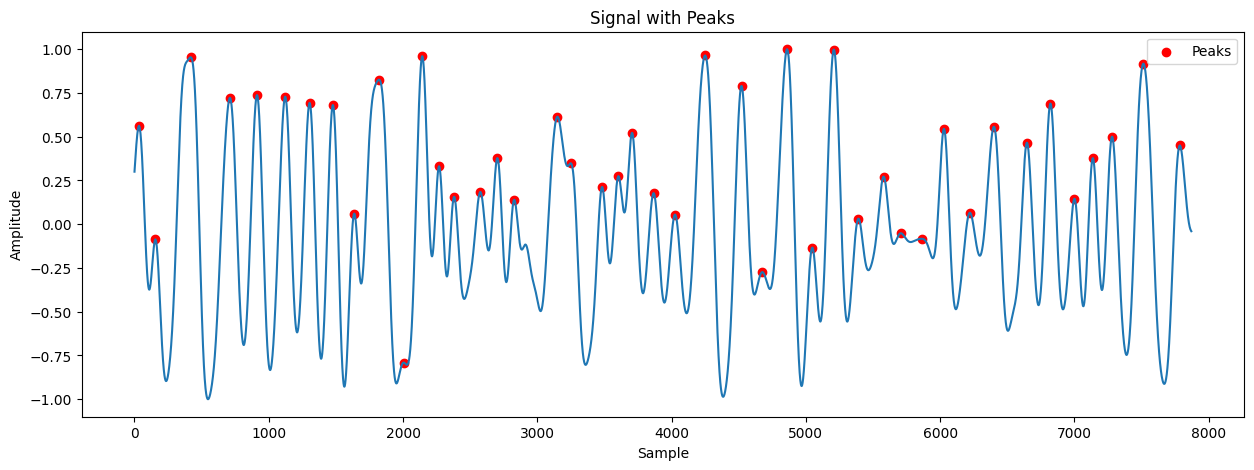

In [7]:
peaks = find_peaks(processed_signal, gt_sample_rate)

# Plot the signal with the peaks
plt.figure(figsize=(15, 5))
plt.plot(processed_signal)
plt.scatter(peaks, processed_signal[peaks], color='r', label='Peaks')
plt.title('Signal with Peaks')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.legend()

plt.show()

In [8]:
print(f'Number of Peaks: {len(peaks)}')
pc_frequency = len(peaks) / (len(processed_signal) / gt_sample_rate)
print(f'Frequency: {pc_frequency:.2f} Hz')

Number of Peaks: 44
Frequency: 0.36 Hz


## Frequency Extraction with Crossing Point

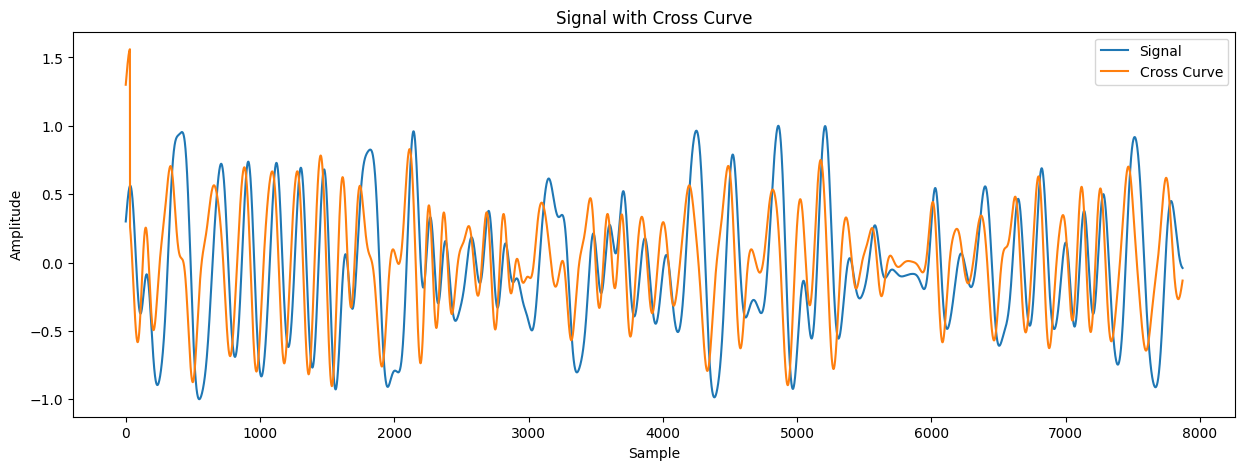

In [9]:
cross_curve = build_cross_curve(processed_signal, gt_sample_rate)

# Plot the signal with the cross curve
plt.figure(figsize=(15, 5))
plt.plot(processed_signal, label='Signal')
plt.plot(cross_curve, label='Cross Curve')
plt.title('Signal with Cross Curve')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.legend()

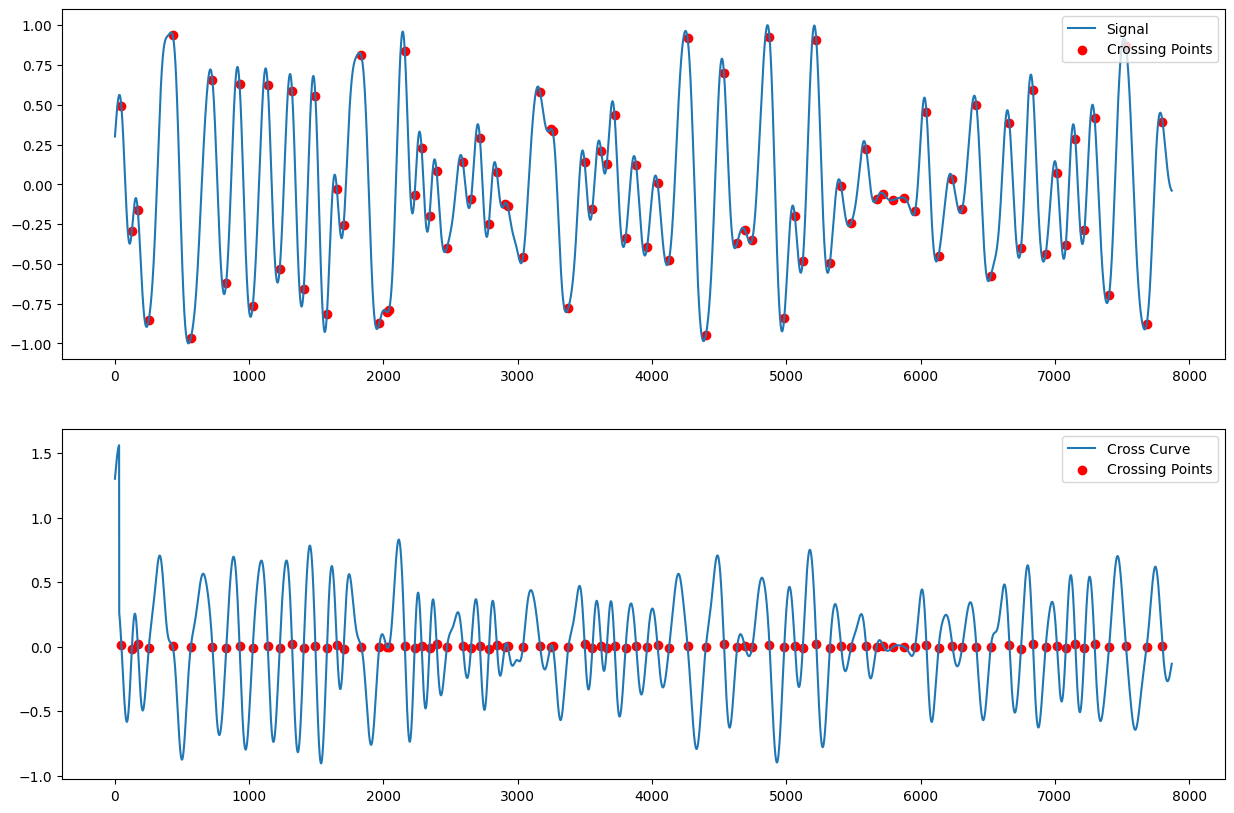

In [10]:
cross_points = find_crossing_points(cross_curve)

cp_fig, axs = plt.subplots(2, 1, figsize=(15, 10))

# Plot the signal with the crossing points
signal_ax = axs[0]
signal_ax.plot(processed_signal, label='Signal')
signal_ax.scatter(cross_points, processed_signal[cross_points], color='r', label='Crossing Points')
signal_ax.legend()

# Plot the signal with the crossing points
cross_curve_ax = axs[1]
cross_curve_ax.plot(cross_curve, label='Cross Curve')
cross_curve_ax.scatter(cross_points, cross_curve[cross_points], color='r', label='Crossing Points')
cross_curve_ax.legend()

In [11]:
print(f'Number of Crossing Points: {len(cross_points)}')
cp_frequency = (len(cross_points) / 2) / (len(processed_signal) / gt_sample_rate)
print(f'Frequency: {cp_frequency:.2f} Hz')

Number of Crossing Points: 89
Frequency: 0.36 Hz


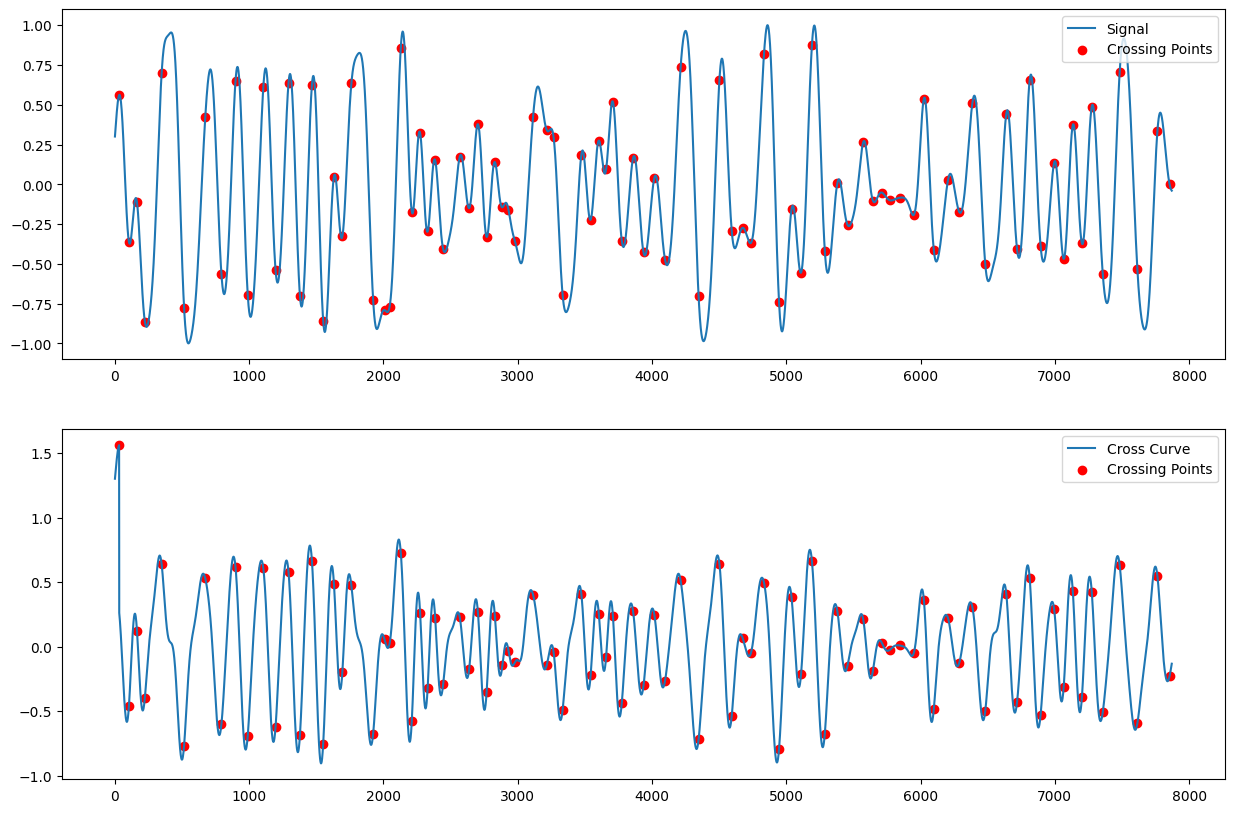

In [12]:
cross_points_nfcp = find_crossing_points_nfcp(cross_curve, gt_sample_rate)

nfcp_fig, axs = plt.subplots(2, 1, figsize=(15, 10))

# Plot the signal with the crossing points
signal_ax = axs[0]
signal_ax.plot(processed_signal, label='Signal')
signal_ax.scatter(cross_points_nfcp, processed_signal[cross_points_nfcp], color='r', label='Crossing Points')
signal_ax.legend()

# Plot the signal with the crossing points
cross_curve_ax = axs[1]
cross_curve_ax.plot(cross_curve, label='Cross Curve')
cross_curve_ax.scatter(cross_points_nfcp, cross_curve[cross_points_nfcp], color='r', label='Crossing Points')
cross_curve_ax.legend()

In [13]:
print(f'Number of Crossing Points: {len(cross_points_nfcp)}')
nfcp_frequency = (len(cross_points_nfcp) / 2) / (len(processed_signal) / gt_sample_rate)
print(f'Frequency: {nfcp_frequency:.2f} Hz')

Number of Crossing Points: 90
Frequency: 0.37 Hz


## Overall Comparison

In [14]:
import respiration.utils as utils

# Calculate the frequencies using the different methods for the ground truth signal
frequency_unprocessed = FrequencyExtractor(
    gt_signal,
    gt_sample_rate,
    lowpass=hyperparameters['filter_lowpass'],
    highpass=hyperparameters['filter_highpass']
)
frequency_processed = FrequencyExtractor(
    processed_signal,
    gt_sample_rate,
    lowpass=hyperparameters['filter_lowpass'],
    highpass=hyperparameters['filter_highpass']
)

gt_frequency = {
    'unprocessed_signal': {
        'FFT': frequency_unprocessed.frequency_from_fft(),
        'PC': frequency_unprocessed.frequency_from_peaks(),
        'CP': frequency_unprocessed.frequency_from_crossing_point(),
        'NFCP': frequency_unprocessed.frequency_from_nfcp()
    },
    'processed_signal': {
        'FFT': frequency_processed.frequency_from_fft(),
        'PC': frequency_processed.frequency_from_peaks(),
        'CP': frequency_processed.frequency_from_crossing_point(),
        'NFCP': frequency_processed.frequency_from_nfcp()
    }
}
utils.pretty_print(gt_frequency)

{
  "processed_signal": {
    "CP": 0.35365853658536583,
    "FFT": 0.1869918699186992,
    "NFCP": 0.36585365853658536,
    "PC": 0.35772357723577236
  },
  "unprocessed_signal": {
    "CP": 0.3617886178861789,
    "FFT": 0.1869918699186992,
    "NFCP": 0.36585365853658536,
    "PC": 0.35772357723577236
  }
}
